In [1]:
# SomeOtherFile.py
from py_grpc_server.loadPlayers import load_all_players
from py_grpc_server.agent_pb2 import Player, DraftStatus, FantasyTeam, GameState, DraftStatus
from typing import List

In [2]:
game_state = GameState()

In [5]:
game_state.players.extend([])

In [3]:
def is_available(player: Player) -> bool:
    return player.draft_status.availability == DraftStatus.Availability.AVAILABLE

def init_team(id: str, name: str, owner: str) -> FantasyTeam:
    team = FantasyTeam()
    team.id = id
    team.name = name
    team.owner = owner
    return team

In [4]:
# Load players from a specified CSV file
players = load_all_players('./player_ranks_2024.csv')
teams = [
    init_team("1", "A", "Alex"),
    init_team("2", "B", "Bob"),
    init_team("3", "C", "Chris"),
    init_team("4", "D", "Darrell"),
    init_team("5", "E", "Emma"),
    init_team("6", "F", "Frank"),
    init_team("7", "G", "Gillian"),
    init_team("8", "H", "Helen"),
    init_team("9", "J", "Jim"),
    init_team("10", "K", "Kevin")
]
game_state = GameState()
game_state.players.extend(players)
game_state.teams.extend(teams)
game_state.current_draft_pick = 1
game_state.total_rounds = 16
game_state.current_bot_team_id = teams[0].id

In [5]:
def draft_player(players: List[Player]) -> str:
    """
    Selects a player to draft based on the highest rank.

    Args:
        players (List[Player]): A list of Player objects.

    Returns:
        str: The id of the drafted player.
    """
    # Filter out already drafted players
    undrafted_players = [player for player in players if is_available(player)]

    # Select the player with the highest rank (lowest rank number)
    if undrafted_players:
        drafted_player = min(undrafted_players, key=lambda p: p.rank)
        return drafted_player.id
    else:
        return ""  # Return empty string if no undrafted players are available

In [6]:
def get_picking_team_index(game_state: GameState, pick: int) -> int:
    number_of_teams = len(game_state.teams)
    # Adjust pick to be zero-based for easier modulo calculations
    pick_adjusted = pick - 1
    
    # Determine the round of the pick
    round_number = pick_adjusted // number_of_teams
    
    # Determine position within the round
    position_in_round = pick_adjusted % number_of_teams
    
    # If the round number is even, order is straightforward
    # If the round number is odd, order is reversed
    if round_number % 2 == 1:
        position_in_round = number_of_teams - 1 - position_in_round
    return position_in_round

def get_picking_team_id(game_state: GameState, pick: int) -> int:
    return game_state.teams[get_picking_team_index(game_state, pick)].id

In [7]:
total_picks = game_state.total_rounds * len(game_state.teams)
while game_state.current_draft_pick <= total_picks:
    player_id = draft_player(game_state.players)
    for player in game_state.players:
        if player.id == player_id:
            player.draft_status.availability = DraftStatus.DRAFTED
            player.draft_status.pick_chosen = game_state.current_draft_pick
            player.draft_status.team_id_chosen = game_state.current_bot_team_id 
    # update for next pick
    game_state.current_draft_pick += 1
    game_state.current_bot_team_id = get_picking_team_id(game_state, game_state.current_draft_pick)

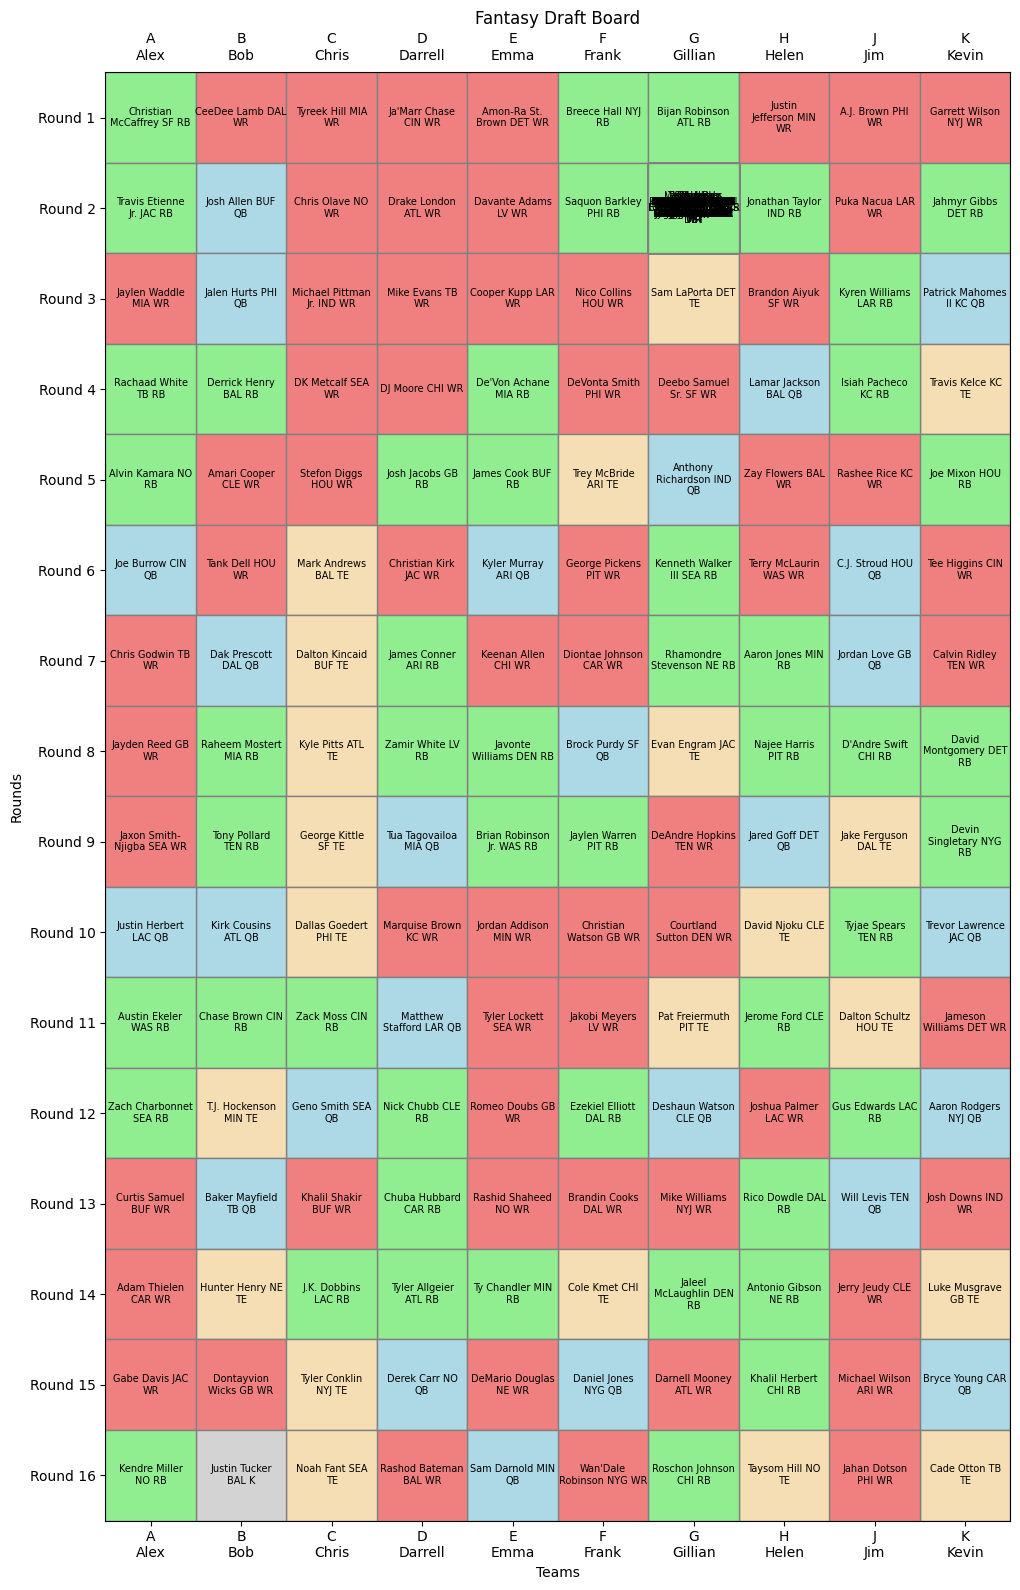

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import textwrap

def wrap_text(text, width):
    """Wrap text to fit within a given width."""
    return '\n'.join(textwrap.wrap(text, width))

# Position-based color configuration (you can customize this)
position_colors = {
    'QB': 'lightblue',
    'RB': 'lightgreen',
    'WR': 'lightcoral',
    'TE': 'wheat',
    'DEF': 'lavender'
}

# Get the number of teams and prepare the board layout
num_teams = len(game_state.teams)
num_rounds = game_state.total_rounds

fig, ax = plt.subplots(figsize=(20, num_rounds )) 
ax.set_xlim(0, num_teams)
ax.set_ylim(0, num_rounds)
ax.set_aspect('equal')  # This makes each box have equal width and height

# Use a smaller font size if needed
font_size = 7

# Plotting each player
for player in game_state.players:
    if player.draft_status.availability != DraftStatus.Availability.DRAFTED:
        continue
    round_number = (player.draft_status.pick_chosen - 1) // num_teams
    team_index = get_picking_team_index(game_state, player.draft_status.pick_chosen)

    # Determine the color based on the first allowed position (assuming the position list is not empty)
    position_color = position_colors.get(player.allowed_positions[0], 'lightgrey')  # Default to lightgrey if no match

    # Create a rectangle for each pick
    rect = patches.Rectangle((team_index, round_number), 1, 1, linewidth=1, edgecolor='gray', facecolor=position_color)
    ax.add_patch(rect)

    # Add player info text over the rectangle
    player_info = f"{player.full_name}\n{player.professional_team}\n{player.allowed_positions[0]}"
    wrapped_text = wrap_text(player_info, 15)
    ax.text(team_index + 0.5, round_number + 0.5, wrapped_text, ha='center', va='center', fontsize=font_size)

# Set the grid and labels
ax.set_xticks([i + 0.5 for i in range(num_teams)])
ax.set_yticks([i + 0.5 for i in range(num_rounds)])
ax.set_xticklabels([f"{team.name}\n{team.owner}" for team in game_state.teams], rotation=0)
ax.set_yticklabels([f"Round {i+1}" for i in range(num_rounds)])
ax.xaxis.set_tick_params(labeltop=True)  # Display team names at the top

plt.gca().invert_yaxis()  # Ensure that the first round starts at the top
plt.title('Fantasy Draft Board')
plt.xlabel('Teams')
plt.ylabel('Rounds')
plt.tight_layout()
plt.show()


In [9]:
import nfl_data_py as nfl
import pandas as pd
pd.set_option('display.max_columns', None)

In [10]:
df = nfl.import_pbp_data([2023], downcast=True, cache=False, alt_path=None)

2023 done.
Downcasting floats.


In [11]:
df = nfl.import_pbp_data([2023])

2023 done.
Downcasting floats.


In [12]:
weekly_df = nfl.import_weekly_data([2023])

Downcasting floats.


In [13]:
player = game_state.players[0]
player_stats = weekly_df[(weekly_df.player_id == player.id) & (weekly_df.season_type == 'REG')]
player_stats["

SyntaxError: EOL while scanning string literal (1509212572.py, line 3)

In [ ]:
season_df = nfl.import_seasonal_data([2023])


In [ ]:
player_df = season_df[(season_df.player_id == player.id)]

In [ ]:
player_df

In [ ]:
season_df

In [ ]:
nfl.import_ids()

In [ ]:
import os

# Print the current working directory
print("Current Working Directory: ", os.getcwd())

from py_grpc_server.stats_db import StatsDB

In [ ]:
from py_grpc_server.stats_db import StatsDB

In [24]:
db = StatsDB([2023, 2022])

Downcasting floats.
2023 done.
2022 done.
Downcasting floats.


In [14]:
player = game_state.players[0]

In [22]:
player

id: "00-0036322"
full_name: "Justin Jefferson"
allowed_positions: "WR"
professional_team: "MIN"
player_bye_week: 1
rank: 1
tier: 1
position_rank: 1
position_tier: 1

In [25]:
db.get_seasonal_data(player)

,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,passing_air_yards,passing_yards_after_catch,passing_first_downs,passing_epa,passing_2pt_conversions,pacr,dakota,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,rushing_2pt_conversions,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr_x,special_teams_tds,fantasy_points,fantasy_points_ppr,games,tgt_sh,ay_sh,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
733,00-0036322,2022,REG,2,2,34.0,0,0.0,0.0,0.0,0,0,3.0,31.0,2.0,3.053086,0,1.375,0.0,4,24.0,1,0.0,0.0,2.0,2.276702,0,128,184,1809.0,8,0.0,0.0,1867.0,613.0,80.0,74.317037,1,17.137723,4.805573,6.710208,11.905504,0.0,240.66,368.66,17,0.273810,0.372283,0.289835,0.708541,0.375467,0.266667,0.327869,0.321168,0.321067,0.353707,2.691964,0.220937
734,00-0036322,2023,REG,0,1,0.0,0,0.0,0.0,0.0,0,0,20.0,0.0,0.0,-0.393326,0,0.000,0.0,1,-12.0,0,0.0,0.0,0.0,-1.971625,0,68,100,1074.0,5,1.0,0.0,1258.0,260.0,51.0,42.822706,0,8.442529,2.813606,4.111504,7.098463,0.0,136.20,204.20,10,0.259067,0.382255,0.223176,0.694405,0.366053,0.250000,0.369565,0.354430,0.308027,0.342843,2.782383,0.221966


In [26]:
db.get_ids(player)

,mfl_id,sportradar_id,fantasypros_id,gsis_id,pff_id,sleeper_id,nfl_id,espn_id,yahoo_id,fleaflicker_id,cbs_id,pfr_id,cfbref_id,rotowire_id,rotoworld_id,ktc_id,stats_id,stats_global_id,fantasy_data_id,swish_id,name,merge_name,position,team,birthdate,age,draft_year,draft_round,draft_pick,draft_ovr,twitter_username,height,weight,college,db_season
1452,14836,4131d4ee-0318-4bb5-832a-4dec80668a4f,19236.0,00-0036322,61398.0,6794.0,NaN,4262921.0,32692.0,NaN,2871343.0,JeffJu00,justin-jefferson-1,14509.0,NaN,542.0,32692.0,0.0,21685.0,1069535.0,Justin Jefferson,justin jefferson,WR,MIN,1999-06-16,25.2,2020.0,1.0,22.0,22.0,JJettas2,73.0,195.0,LSU,2024


In [21]:
import pandas as pd
pd.set_option('display.max_columns', None)
db.pbp_df

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

In [14]:
team = game_state.teams[0]

In [16]:
team.draft_function = draft_player

AttributeError: Assignment not allowed to message, map, or repeated field "draft_function" in protocol message object.

In [18]:
team.draft_function